# Run Test 3.30.23
- 9 days (465 x 9 x 7000= 29M total FFTs, 2^24, 660MHz clock) 
- switch antenna and term (switch=1 is terminator. 1/16 duty cycle) 
- 4dB fixed attenuation, pasternack 1012 to mini circuits zkl1r5+ (9V regulated from battery). 
- Run started 4-19-23 at 16:19:15. 
- Right at clipping

In [24]:
import sys 
import numpy as np
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime
import pandas as pd

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/RunData/run1p3_4_19_23/main_data/'

totalAcqs       = int(open(s.SAVE_DIRECTORY + 'database.txt', 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    
# Generate antIdx and termIdx from database file

# Open the data file and read the lines
with open(dataDir + filename, 'r') as f:
    # Skip the header line
    next(f)
    # Initialize the two arrays
    antIdx = []
    termIdx = []
    # Loop through the remaining lines and extract the acqNum values
    for line in f:
        # Split the line into fields
        fields = line.strip().split(',')
        # Extract the SWITCH_POS and ACQ NUM values
        switch_pos = int(fields[2])
        acq_num = int(fields[0])
        # Append the acqNum value to the appropriate array
        if switch_pos == 0:
            antIdx.append(acq_num)
        elif switch_pos == 1:
            termIdx.append(acq_num)

# Print the results
print("antIdx =", antIdx)
print("termIdx =", termIdx)




1392
antIdx = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 

diff mean:              184.85698625161754
diff median:            178.404585
diff STD:               172.85467523866905
diff percent error:     93.50724511076277
expected single time:   6.355006060606061
total time:             257136.067876
expected total time:    82742.1789090909


Text(0, 0.5, 'Time Delta (Seconds)')

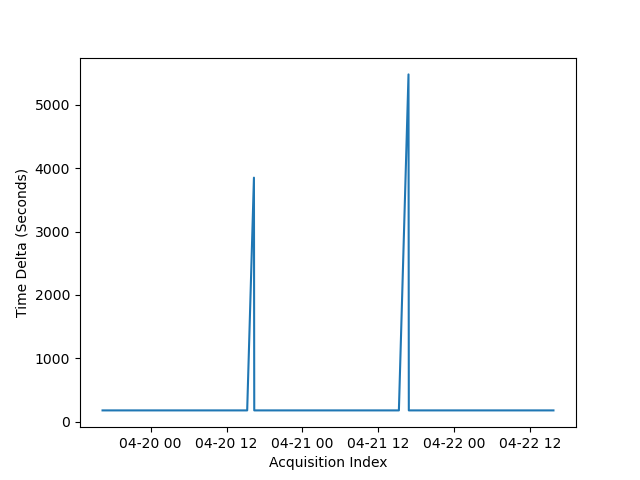

In [9]:
#time delta analysis
datetimes_str = np.loadtxt(f'{dataDir}database.txt',
                        skiprows=1,
                        usecols=1,
                        delimiter=',',
                        dtype=str)
datetimes =[]
for date in datetimes_str:
    data = date[10]
    datetimes.append(datetime.strptime(date, ' %Y-%m-%d %H:%M:%S.%f'))


diff = []
for i in range(len(datetimes)-1):
    diff.append((datetimes[i+1] - datetimes[i]).total_seconds())

print(f"diff mean:              {np.mean(diff)}")
print(f"diff median:            {np.median(diff)}")
print(f"diff STD:               {np.std(diff)}")
print(f"diff percent error:     {np.std(diff)/np.mean(diff) * 100}")
print(f"expected single time:   {2**24/s.SAMPLE_RATE * 250}")
print(f"total time:             {(datetimes[-1] - datetimes[0]).total_seconds()}")
print(f"expected total time:    {2**24/s.SAMPLE_RATE * s.NOF_BUFFERS_TO_RECEIVE * s.NOF_ACQUISITIONS_TO_TAKE}")

plt.close('all')
plt.figure()
plt.plot(datetimes[1:], diff)
plt.xlabel('Acquisition Index')
plt.ylabel('Time Delta (Seconds)')

In [15]:
#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    specA_W    = f.create_dataset('spec_W_chA', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    specB_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(specA_W)
    print(specB_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 1 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            print(measData)
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''
            specA_W_np        = np.float32(dataset[measData]['chASpec_W'])
            specB_W_np        = np.float32(dataset[measData]['chBSpec_W'])


            specA_W[:, measDataInt]    = specA_W_np
            specB_W[:, measDataInt]    = specB_W_np

f.close()

closed
initilizing dataset 8388609x1392
<HDF5 dataset "spec_W_chA": shape (8388609, 1392), type "<f4">
<HDF5 dataset "spec_W_chB": shape (8388609, 1392), type "<f4">
0.hdf5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1.hdf5
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2.hdf5
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
3.hdf5
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
4.hdf5
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
5.hdf5
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
6.hdf5
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
7.hdf5
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
8.hdf5
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
9.hdf5
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
10.hdf5
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
11.hdf5
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
12.hdf5
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
13.hdf5
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
14

ValueError: Index (1392) out of range (0-1391)

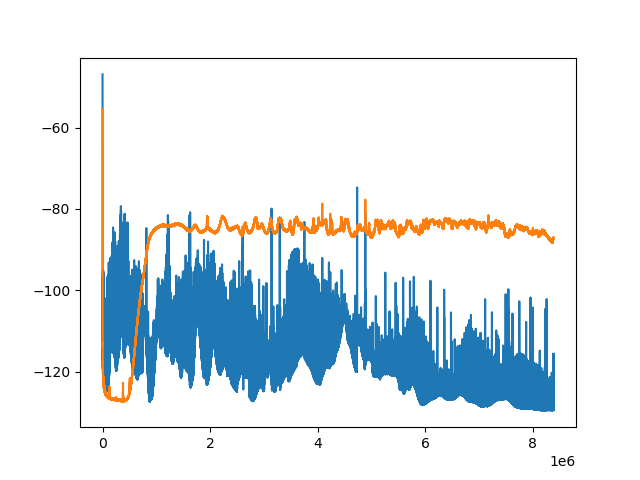

In [21]:
f               = h5py.File(newDataDir + fileName, 'r')
vetoSpec = f['spec_W_chA'][:,0]
antSpec  = f['spec_W_chB'][:,0]
f.close()

plt.close('all')
plt.figure()
plt.plot(10*np.log10(vetoSpec*1000))
plt.plot(10*np.log10(antSpec*1000))


In [27]:
#Average and save spectra

#location of packed h5
fileName        = 'packedh5.hdf5'


f               = h5py.File(dataDir + fileName, 'r')

def avgSpecFromPacked(avgIdxs, specStr):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f[specStr][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

def rollingMadLim(spec,
    nSigma = 1,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

#Average, filter and save
if 1:
    antIdxs     = range(0, totalAcqs-1, 2)[0:-1]
    termIdxs    = range(1, totalAcqs-1, 2)
    #avgAntSpec  = avgSpecFromPacked(antIdx, 'spec_W_chB')
    #avgVetoSpec  = avgSpecFromPacked(antIdx, 'spec_W_chA')
    #avgTermSpec = avgSpecFromPacked(termIdx, 'spec_W_chB')

    np.save('./avgSpecs_gitignore/avgAntSpec_W_9e6FFTs_4_22_23', avgAntSpec)
    np.save('./avgSpecs_gitignore/avgVetoSpec_W_9e6FFTs_4_22_23', avgVetoSpec)
    np.save('./avgSpecs_gitignore/avgTermSpec_W_6p5e5FFTs_4_22_23', avgTermSpec)
    print('Done saving raw spectra')

    #filter/rolling mad limit and save
    antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
    termRollingMadLim, termFilt, nSigma, order, fc_numBins   = rollingMadLim(avgTermSpec)

    np.save(f'./avgSpecs_gitignore/antRollingMadLim_W_9p6e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_22_23', antRollingMadLim)
    np.save(f'./avgSpecs_gitignore/termRollingMadLim_W_6p5e5FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_22_23', termRollingMadLim)

    np.save(f'./avgSpecs_gitignore/antFilt_W_9p6e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_22_23', antFilt)
    np.save(f'./avgSpecs_gitignore/termFilt_W_6p5e5FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_4_22_23', termFilt)

    f.close()


Done saving raw spectra
done mp
done mp


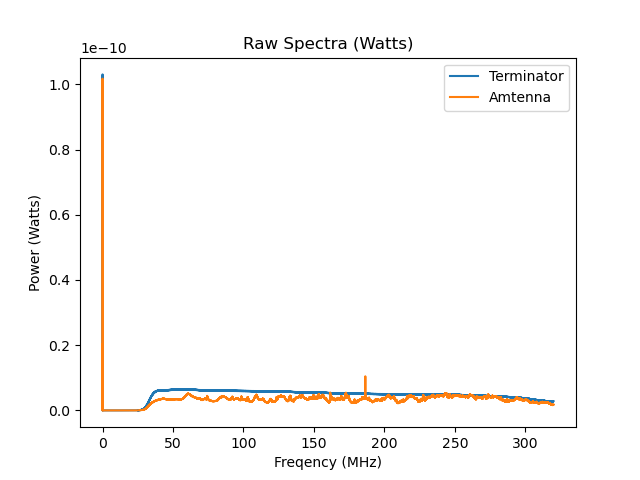

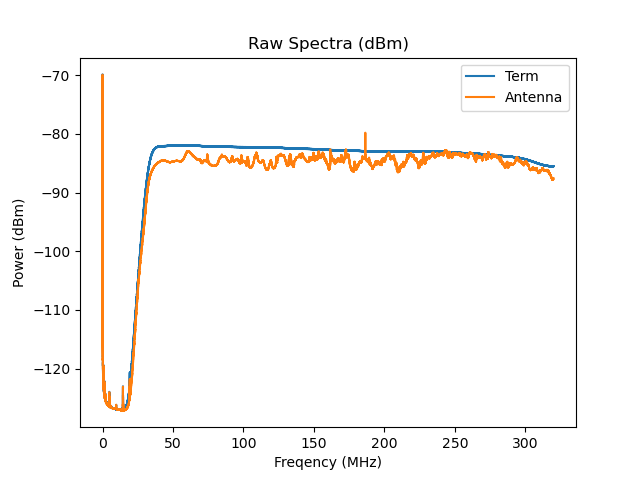

In [59]:
#load files generated in previous cell
# only saved nSigma=1, changing nSigma just multplies the rolling mad limit in this cell
nSigma      = 4
order       = 1
fc_numBins  = 100

avgAntSpec          = np.load('./avgSpecs_gitignore/avgAntSpec_W_9e6FFTs_4_22_23.npy', allow_pickle=True)
avgTermSpec         = np.load('./avgSpecs_gitignore/avgTermSpec_W_6p5e5FFTs_4_22_23.npy', allow_pickle=True)
avgVetoSpec         = np.load('./avgSpecs_gitignore/avgVetoSpec_W_9e6FFTs_4_22_23.npy', allow_pickle=True)

filtAntSpec         = np.load(f'./avgSpecs_gitignore/antFilt_W_9p6e6FFTs_nSigma1_order{order}_fc{fc_numBins}_4_22_23.npy', 
    allow_pickle=True
)
filtTermSpec        = np.load(f'./avgSpecs_gitignore/termFilt_W_6p5e5FFTs_nSigma1_order{order}_fc{fc_numBins}_4_22_23.npy', 
    allow_pickle=True
)
termRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/termRollingMadLim_W_6p5e5FFTs_nSigma1_order{order}_fc{fc_numBins}_4_22_23.npy',
    allow_pickle=True
)
antRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/antRollingMadLim_W_9p6e6FFTs_nSigma1_order{order}_fc{fc_numBins}_4_22_23.npy',
    allow_pickle=True
)


#plot raw spectra
freqs       = np.linspace(0, 320, 2**23, dtype=np.float64)

plt.close('all')

plt.title('Raw Spectra (Watts)')
plt.plot(freqs, avgTermSpec[1:], label = 'Terminator')
plt.plot(freqs, avgAntSpec[1:], label = 'Amtenna')
plt.ylabel('Power (Watts)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Raw Spectra (dBm)')
plt.plot(freqs, 10*np.log10(avgTermSpec[1:]*1000), label = 'Term')
plt.plot(freqs, 10*np.log10(avgAntSpec[1:]*1000), label = 'Antenna')
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')


nSigma: 4
1875 antenna candidates
217 term candidates


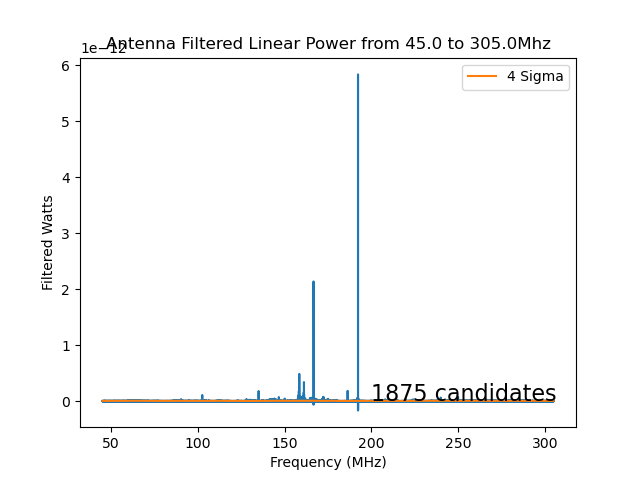

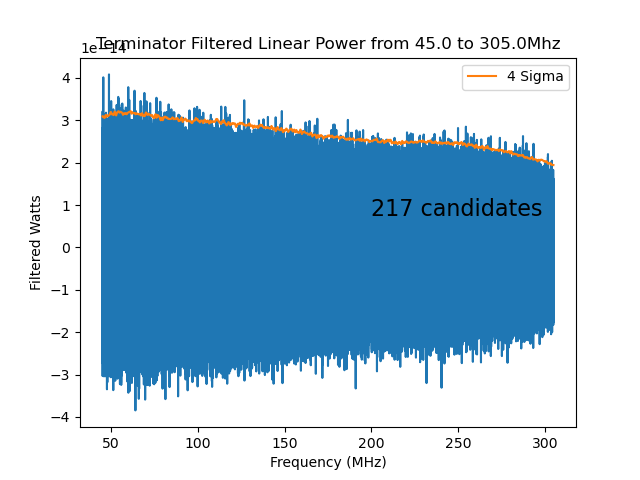

In [60]:
print(f'nSigma: {nSigma}')

pltFreqStart = 45e6
pltFreqStop = 305e6
freqs=np.linspace(0,660e6/2, 2**23)
pltIdxStart = freq2Idx(pltFreqStart, freqs)
pltIdxStop = freq2Idx(pltFreqStop, freqs)

antCanList_idx = ((filtAntSpec > antRollingMadLim)) 
antCandidateTotal = (antCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{antCandidateTotal} antenna candidates")

termCanList_idx = ((filtTermSpec > termRollingMadLim)) 
termCandidateTotal = (termCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{termCandidateTotal} term candidates")


plt.close('all')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(antRollingMadLim)[pltIdxStart:pltIdxStop], label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{antCandidateTotal} candidates',size=16)
plt.title(f"Antenna Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(termRollingMadLim)[pltIdxStart:pltIdxStop],label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
plt.title(f"Terminator Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')

if 0:
    plt.figure()
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop], label = 'Antenna')
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop], label = 'Terminator', alpha = .5)
    plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
    plt.title(f"Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Filtered Watts')
    plt.legend(loc = 'upper right')

In [57]:
#generate lists of candidates

antCanIdx   = (np.where(antCanList_idx  == True))[0]
termCanIdx  = (np.where(termCanList_idx == True))[0]

antMask     = (antCanIdx >= pltIdxStart) & (antCanIdx <= pltIdxStop)
termMask    = (termCanIdx >= pltIdxStart) & (termCanIdx <= pltIdxStop)

antCanIdx   = antCanIdx[antMask]
termCanIdx  = termCanIdx[termMask]

antCanFreqs =np.asarray([idx2freq(idx,freqs) for idx in antCanIdx])
termCanFreqs=np.asarray([idx2freq(idx,freqs) for idx in termCanIdx])



print(len(antCanFreqs), 'antenna candidates')
#print('at freqs. ', antCanFreqs/1e6)
print(len(termCanFreqs), 'terminator candidates')
print('at freqs. ', termCanFreqs/1e6)

1086 antenna candidates
0 terminator candidates
at freqs.  []


In [48]:
def consolidateCandidates(rawCanList, freqs, stepsize=1):
    '''
    Takes array of indices of candidates and returns a data frame
    with one row per candidate and columns with the candidate frequency,
    number of bins wide and the starting index of that candidate
    Inputs:
        rawCanList (1D list or np array): list of indices of candidates
        reqs (1D list or np array): list of frequencies
        stepsize: should be 1 to find adjecent candidates
    Calls:
        idx2Freq()
    '''
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    canList = [can[0] for can in splitList]
    canListFreq =  [idx2freq(can[0],freqs) for can in splitList]
    canLenList = [len(can) for can in splitList]
    candidate_df = pd.DataFrame()
    candidate_df['canFreq_Mhz'] = [freq/1e6 for freq in canListFreq]
    candidate_df['numBins'] = canLenList
    candidate_df['idx'] = canList
    #candidate_df['idx absolute'] = [idx + idxStart for idx in canList]
    diffArr = np.zeros(len(canList))
    diffArr[0] =  float('nan')
    diffArr[1:] = np.diff(canList)
    candidate_df['deltaIdx'] = diffArr
    candidate_df['deltaFreq_Hz'] = [deltaIdx* (s.SAMPLE_RATE) /s.CH0_RECORD_LEN for deltaIdx in diffArr]

    return candidate_df

stepsize = 10
candidate_df = consolidateCandidates(antCanIdx, freqs, stepsize=stepsize)
#candidate_df.to_csv(f'candidateListCsvs/candidateList_diffGreaterThan10Bins_{nSigma}sigma_fc100bins_Order1_4_3_23.csv')
candidate_df

,canFreq_Mhz,numBins,idx,deltaIdx,deltaFreq_Hz
0,90.299953,1,2295427,NaN,NaN
1,102.499902,6,2605550,310123.0,1.219995e+07
2,127.998973,1,3253737,648187.0,2.549907e+07
3,129.999994,1,3304603,50866.0,2.001021e+06
4,134.999989,2,3431703,127100.0,4.999995e+06
...,...,...,...,...,...
196,223.998173,1,5694039,101677.0,3.999878e+06
197,224.998251,1,5719461,25422.0,1.000078e+06
198,240.000597,2,6100821,381360.0,1.500235e+07
199,250.000863,1,6355028,254207.0,1.000027e+07


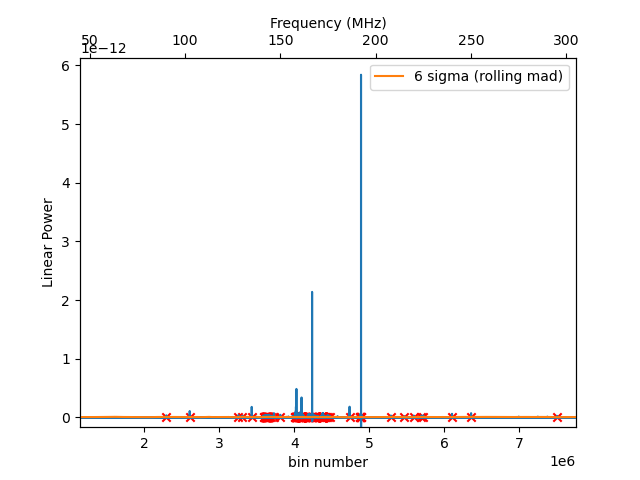

stepsize = 10 
butter filter (order = 1 and f_c = 100 bins)
number of candidates =  201


In [58]:

fig, ax = plt.subplots()

ax.plot(np.arange(0, len(freqs), 1), np.zeros(len(freqs)), alpha = 0)
ax.set_xlabel('bin number')
ax.xaxis.tick_top()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_ticks_position('top')
ax.set_xlim(pltIdxStart, pltIdxStop)
ax.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
    np.max(filtAntSpec[pltIdxStart:pltIdxStop]*1.05)
)
ax.set_ylabel('Linear Power')

ax2 = ax.twiny()

ax2.plot(freqs/1e6, filtAntSpec[1:])
ax2.plot(freqs/1e6,  antRollingMadLim[1:], label = f'{nSigma} sigma (rolling mad)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Linear Power (W)')


#ax2.plot(np.arange(pltIdxStart, pltIdxStop, 1), antRollingMadLim[pltIdxStart:pltIdxStop], 'orange', label = '5 sigma (rolling mad)')
ax2.scatter(freqs[candidate_df['idx']]/1e6, antRollingMadLim[candidate_df['idx']], color ='r', marker = 'x')
ax2.set_xlim(pltFreqStart/1e6, pltFreqStop/1e6)
#ax2.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
#    np.max(filtAntSpec[pltIdxStart:pltIdxStop])
#)

ax2.legend(loc = 'upper right')
ax2.xaxis.tick_top()

plt.show()

print('stepsize = %i ' %stepsize)
print('butter filter (order = %i and' %order, 'f_c = %i'  %fc_numBins, 'bins)')

print('number of candidates = ', len(candidate_df['idx']) )

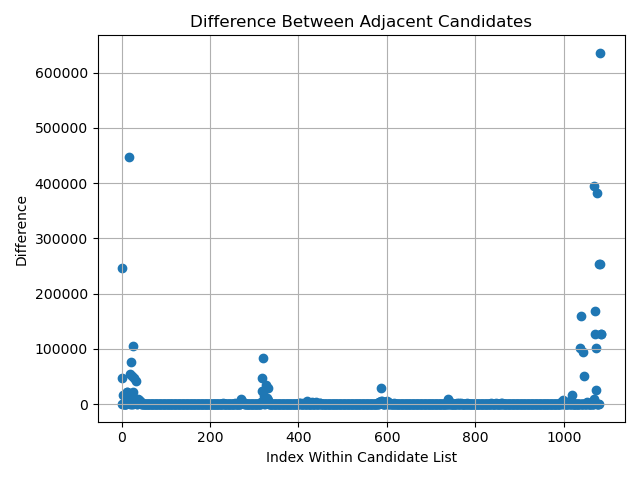

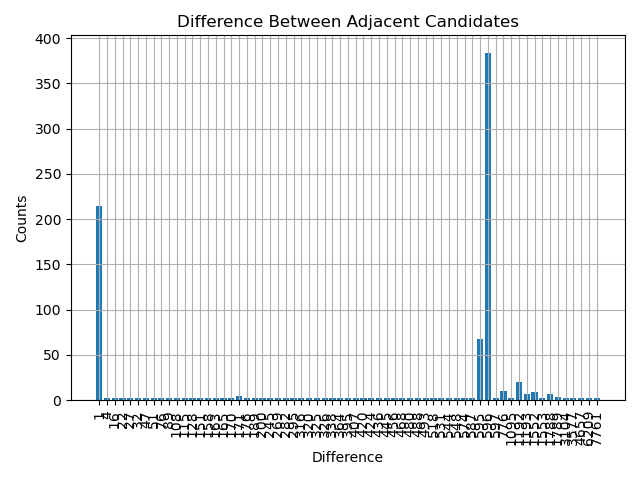

In [43]:
#create a list of bunches of spurs
print()
idxDiff = np.diff(antCanIdx)
#print(idxDiff)
diffMask = np.where(idxDiff == 1, True, False)
diffMask = np.append(False, diffMask,)

onesIdxs = antCanIdx[diffMask]
#print(freqs[onesIdxs])

hist, binEdges = np.histogram(idxDiff, bins = 10000, range=(1,10001))
#print(binEdges)
histNoZeros = []
binsNoZeros = []
for i, val in enumerate(hist):
    if val != 0 and val != 1:
        histNoZeros.append(val)
        binsNoZeros.append(binEdges[i])
binsNoZeros =[str(int(bin)) for bin in binsNoZeros]

plt.close('all')
plt.figure()
#plt.semilogy()
plt.scatter(np.arange(0, len(idxDiff), 1),(idxDiff))
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Index Within Candidate List')
plt.ylabel('Difference')
plt.grid()
plt.tight_layout()

#hist without skipping empty bins. Not useful
if 0:
    plt.figure();
    plt.hist(idxDiff, bins = 10000, range=(2,10002));
    plt.title('Difference Between Adjacent Candidates')
    plt.xlabel('Difference')
    plt.ylabel('Counts')

#hist skipping unused bins
plt.figure();
plt.bar(binsNoZeros, histNoZeros);
plt.title('Difference Between Adjacent Candidates');
plt.xlabel('Difference');
plt.ylabel('Counts');
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.grid()